In [1]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession,SQLContext 
from google.colab import drive
from pyspark.sql.types import DateType,DoubleType,IntegerType
from pyspark.sql.functions import *
import numpy as np

In [3]:
spark = SparkSession.builder.master("local[*]").appName('Isuru_DS_DE_Internship').getOrCreate()

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#loading appropriate datasets
GS_Sales_Data = spark.read.csv('/content/drive/MyDrive/SurgeGlobal/DS_DE Internship - GS Sales Data 2022.v2.xlsx - GS Sales Data.csv',sep = ',',header = True,inferSchema=True,)
Daily_Target = spark.read.csv('/content/drive/MyDrive/SurgeGlobal/DS_DE Internship - GS Sales Data 2022.v2.xlsx - Daily Target.csv',sep = ',',header = True,inferSchema=True)

In [6]:
GS_Sales_Data.show(5)

+------+--------------+----------+----------+---------+---------+--------------+-----------+-------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+-------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date|Order_Week|Ship Date|Ship_Week|     Ship Mode|Customer ID|Customer Name|    Segment|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|       Category|Sub-Category|        Product Name|  Sales|Quantity|Discount|  Profit|Returned|
+------+--------------+----------+----------+---------+---------+--------------+-----------+-------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+-------+--------+--------+--------+--------+
|     1|US-2019-103800|  1/3/2019|    2019-1| 1/7/2019|   2019-2|Stand

In [7]:
#basic information about the dataset
GS_Sales_Data.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- Profit: double (nullable = true)


In [8]:
GS_Sales_Data.count()

10194

In [9]:
#discriptive summary of the dataset
GS_Sales_Data.describe().show()

+-------+-----------------+--------------+----------+----------+---------+---------+--------------+-----------+------------------+-----------+--------------+--------+--------------+-----------------+-------+----------------+---------------+----------+------------+--------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|           Row ID|      Order ID|Order Date|Order_Week|Ship Date|Ship_Week|     Ship Mode|Customer ID|     Customer Name|    Segment|Country/Region|    City|State/Province|      Postal Code| Region|Regional Manager|     Product ID|  Category|Sub-Category|        Product Name|             Sales|          Quantity|           Discount|            Profit|          Returned|
+-------+-----------------+--------------+----------+----------+---------+---------+--------------+-----------+------------------+-----------+--------------+--------+--------------+-----------------+-------+----------------+------------

In [10]:
#drop duplicates from the dataset
GS_Sales_Data_duplicates=GS_Sales_Data.groupBy(GS_Sales_Data.columns).count().filter("count > 1")
GS_Sales_Data_duplicates.drop('count')
GS_Sales_Data_duplicates.count()

0

In [11]:
#casting wrong data types into correct data types
GS_Sales_Data = GS_Sales_Data\
.withColumn("Order Date" , to_date(col("Order Date"),'M/d/yyyy'))\
.withColumn("Ship Date"  ,to_date(col("Ship Date"),'M/d/yyyy'))\
.withColumn("Sales"  ,GS_Sales_Data["Sales"].cast(DoubleType()))\
.withColumn("Quantity"  ,GS_Sales_Data["Quantity"].cast(DoubleType()))\
.withColumn("Discount"  ,GS_Sales_Data["Discount"].cast(DoubleType()))

In [12]:
#final schema after casting data types
GS_Sales_Data.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |--

In [13]:
GS_Sales_Data.show(5)

+------+--------------+----------+----------+----------+---------+--------------+-----------+-------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+-------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date|Order_Week| Ship Date|Ship_Week|     Ship Mode|Customer ID|Customer Name|    Segment|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|       Category|Sub-Category|        Product Name|  Sales|Quantity|Discount|  Profit|Returned|
+------+--------------+----------+----------+----------+---------+--------------+-----------+-------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+-------+--------+--------+--------+--------+
|     1|US-2019-103800|2019-01-03|    2019-1|2019-01-07|   2019-2|S

In [14]:
Daily_Target.show(5)

+---------------+----------+-----------+------------+
|       Category|Order Date|    Segment|Sales Target|
+---------------+----------+-----------+------------+
|Office Supplies|  1/3/2019|   Consumer|          15|
|Office Supplies|  1/4/2019|Home Office|         300|
|Office Supplies|  1/5/2019|   Consumer|          21|
|      Furniture|  1/6/2019|Home Office|        2316|
|Office Supplies|  1/6/2019|   Consumer|          17|
+---------------+----------+-----------+------------+
only showing top 5 rows



In [15]:
Daily_Target.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Sales Target: integer (nullable = true)



In [16]:
Daily_Target.count()

4603

In [17]:
Daily_Target.describe().show()

+-------+----------+----------+-----------+-----------------+
|summary|  Category|Order Date|    Segment|     Sales Target|
+-------+----------+----------+-----------+-----------------+
|  count|      4603|      4603|       4603|             4603|
|   mean|      null|      null|       null|486.7262654790354|
| stddev|      null|      null|       null|985.1143915441062|
|    min| Furniture|  1/1/2022|   Consumer|                1|
|    max|Technology|  9/9/2022|Home Office|            25729|
+-------+----------+----------+-----------+-----------------+



In [18]:
Daily_Target_duplicates=Daily_Target.groupBy(Daily_Target.columns).count().filter("count > 1")
Daily_Target_duplicates.drop('count')
Daily_Target_duplicates.count()

0

In [19]:
Daily_Target = Daily_Target\
.withColumn("Order Date"  ,to_date(col("Order Date"),'M/d/yyyy'))

In [20]:
Daily_Target.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Sales Target: integer (nullable = true)



In [21]:
Daily_Target.show(5)

+---------------+----------+-----------+------------+
|       Category|Order Date|    Segment|Sales Target|
+---------------+----------+-----------+------------+
|Office Supplies|2019-01-03|   Consumer|          15|
|Office Supplies|2019-01-04|Home Office|         300|
|Office Supplies|2019-01-05|   Consumer|          21|
|      Furniture|2019-01-06|Home Office|        2316|
|Office Supplies|2019-01-06|   Consumer|          17|
+---------------+----------+-----------+------------+
only showing top 5 rows



In [22]:
# Renaming the columns for identification purposes for later processes
Daily_Target_R = Daily_Target.withColumnRenamed("Category", "Category_DT")\
                           .withColumnRenamed("Order Date", "Order_Date_DT")\
                           .withColumnRenamed("Segment", "Segment_DT")

In [23]:
# Specifying the joining conditions for the joins of the dataframes  "GS_Sales_Data" and "Daily_Target"
condition = [GS_Sales_Data['Category']== Daily_Target_R['Category_DT'], GS_Sales_Data['Order Date']== Daily_Target_R['Order_Date_DT'], GS_Sales_Data['Segment']==Daily_Target_R['Segment_DT']]

# Executing an inner join accross the prior mentioned dataframes
GS_Sales_Data_Combined = GS_Sales_Data.join(Daily_Target_R, condition, 'inner',)

GS_Sales_Data_Combined= GS_Sales_Data_Combined.drop('Category_DT', 'Order_Date_DT', 'Segment_DT')
GS_Sales_Data_Combined = GS_Sales_Data_Combined.sort('Order Date')

GS_Sales_Data_Combined.show()
GS_Sales_Data_Combined.printSchema()

+------+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+-------+--------+--------+--------+--------+------------+
|Row ID|      Order ID|Order Date|Order_Week| Ship Date|Ship_Week|     Ship Mode|Customer ID|   Customer Name|    Segment|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|       Category|Sub-Category|        Product Name|  Sales|Quantity|Discount|  Profit|Returned|Sales Target|
+------+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+-------+--------+--------+--------+--------+------------+
|     1|US-2019-103

In [24]:
GS_Sales_Data_Combined.count()

10112

In [25]:
#for i in range(0,len(GS_Sales_Data_Combined_.columns)):
#  GS_Sales_Data_Combined_NA = GS_Sales_Data_Combined_NA[GS_Sales_Data_Combined_NA.columns[i]].replace({'#N/A':None})

In [26]:
#from pyspark.sql.functions import when, count, col

#cols=GS_Sales_Data_Combined.columns
#cols.pop(2)
#cols.pop(3)
#GS_Sales_Data_Combined.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

In [27]:
#import missingno as msno
#msno.bar(GS_Sales_Data_Combined_NA)

In [28]:
GS_Sales_Data_Combined.select('Returned').distinct().show()

+--------+
|Returned|
+--------+
|  2.8478|
|   15.49|
|  26.973|
|  4.2717|
|-10.6547|
|   3.178|
|-18.0312|
| 73.5448|
| 10.3904|
| 11.1024|
|   3.339|
| 34.0704|
| 30.9918|
|   3.405|
|  6.7655|
| 39.3408|
| 22.7136|
|-26.6352|
|   7.668|
| -4.7625|
+--------+
only showing top 20 rows



In [29]:
#creating sales fact table
Sales_fact = GS_Sales_Data_Combined.select(['Order ID', 'Product ID','Product Name', 'Customer ID', 'Postal Code','City', 'Region','Returned' ,'Quantity', 'Discount', 'Profit', 'Sales', 'Sales Target'])

#replace NA values by zero
Sales_fact = Sales_fact.withColumn('Returned',when(Sales_fact["Returned"] == '#N/A', 0).otherwise(Sales_fact["Returned"]))
#Sales_fact = Sales_fact.withColumn("Returned", col("Returned").cast(IntegerType()))
#Sales_fact = Sales_fact.na.fill(value=0,subset=["Returned"])
Sales_fact.printSchema()
Sales_fact.show()

root
 |-- Order ID: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Returned: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Sales Target: integer (nullable = true)

+--------------+---------------+--------------------+-----------+-----------+------------+-------+--------+--------+--------+--------+-------+------------+
|      Order ID|     Product ID|        Product Name|Customer ID|Postal Code|        City| Region|Returned|Quantity|Discount|  Profit|  Sales|Sales Target|
+--------------+---------------+--------------------+-----------+-----------+------------+-------+--------+--------+--------+--------+-------+------------+


In [30]:
#distinct values in category column
GS_Sales_Data_Combined.select("Category").distinct().show()

+---------------+
|       Category|
+---------------+
|Office Supplies|
|      Furniture|
|     Technology|
+---------------+



In [31]:
#creating product dimension table
Product_dim = GS_Sales_Data_Combined.select(['Product ID', 'Product Name', 'Category', 'Sub-Category'])

#show unique rows
Product_dim = Product_dim.distinct()

Product_dim.printSchema()
#sort by product ID
Product_dim = Product_dim.sort('Product ID')
Product_dim.show()

root
 |-- Product ID: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)

+---------------+--------------------+---------+------------+
|     Product ID|        Product Name| Category|Sub-Category|
+---------------+--------------------+---------+------------+
|FUR-BO-10000112|Bush Birmingham C...|Furniture|   Bookcases|
|FUR-BO-10000330|Sauder Camden Cou...|Furniture|   Bookcases|
|FUR-BO-10000362|Sauder Inglewood ...|Furniture|   Bookcases|
|FUR-BO-10000468|O'Sullivan 2-Shel...|Furniture|   Bookcases|
|FUR-BO-10000711|Hon Metal Bookcas...|Furniture|   Bookcases|
|FUR-BO-10000780|O'Sullivan Planta...|Furniture|   Bookcases|
|FUR-BO-10001337|O'Sullivan Living...|Furniture|   Bookcases|
|FUR-BO-10001519|O'Sullivan 3-Shel...|Furniture|   Bookcases|
|FUR-BO-10001567|Bush Westfield Co...|Furniture|   Bookcases|
|FUR-BO-10001601|Sauder Mission Li...|Furniture|   Bookcases|
|FUR-BO-10001608|H

In [32]:
#get distinct values of regional manager column
GS_Sales_Data_Combined.select('Regional Manager').distinct().show()

+-----------------+
| Regional Manager|
+-----------------+
|      Fred Suzuki|
|      Chuck Magee|
|  Sadie Pawthorne|
|Roxanne Rodriguez|
|             #N/A|
+-----------------+



In [33]:
# checking for the Regions where Regional Manager is equal to #NA
GS_Sales_Data_Combined.select('Region', 'Regional Manager').where(GS_Sales_Data_Combined['Regional Manager']=='#N/A').distinct().show()

# checking for the Regions where Regional Manager is not equal to #NA
GS_Sales_Data_Combined.select('Region', 'Regional Manager').where(GS_Sales_Data_Combined['Regional Manager']!='#N/A').distinct().show()

#creating employee dimension table
Employee_dim = GS_Sales_Data_Combined.select(['Region' , 'Regional Manager'])

Employee_dim = Employee_dim.withColumn("Regional Manager", \
               when(Employee_dim["Region"] == 'West', 'Sadie Pawthorne')\
              .when(Employee_dim["Region"] == 'Central', 'Roxanne Rodriguez')\
              .when(Employee_dim["Region"] == 'South', 'Fred Suzuki')\
              .when(Employee_dim["Region"] == 'East', 'Chuck Magee').otherwise(Employee_dim["Regional Manager"]))

Employee_dim = Employee_dim.distinct() 
Employee_dim.printSchema()
Employee_dim.show(10)

+-------+----------------+
| Region|Regional Manager|
+-------+----------------+
|   West|            #N/A|
|Central|            #N/A|
|  South|            #N/A|
|   East|            #N/A|
+-------+----------------+

+-------+-----------------+
| Region| Regional Manager|
+-------+-----------------+
|Central|Roxanne Rodriguez|
|   West|  Sadie Pawthorne|
|  South|      Fred Suzuki|
|   East|      Chuck Magee|
+-------+-----------------+

root
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)

+-------+-----------------+
| Region| Regional Manager|
+-------+-----------------+
|Central|Roxanne Rodriguez|
|   West|  Sadie Pawthorne|
|  South|      Fred Suzuki|
|   East|      Chuck Magee|
+-------+-----------------+



Since there are only 4 regional managers and 4 regions we assumed one manager is related to one region and we found regional managers related to regions by retrieving not null columns and replaced the relevent managers in to null columns

In [34]:
#creating state dimension table
state_dim = GS_Sales_Data_Combined.select(['Postal Code','City','Country/Region' , 'State/Province','Region'])
state_dim.show(5)


+-----------+------------+--------------+--------------+-------+
|Postal Code|        City|Country/Region|State/Province| Region|
+-----------+------------+--------------+--------------+-------+
|      77095|     Houston| United States|         Texas|Central|
|      60540|  Naperville| United States|      Illinois|Central|
|      60540|  Naperville| United States|      Illinois|Central|
|      60540|  Naperville| United States|          #N/A|Central|
|      19143|Philadelphia| United States|  Pennsylvania|   East|
+-----------+------------+--------------+--------------+-------+
only showing top 5 rows



In [35]:
#extract postal code and state columns which no null values included
df_postal =GS_Sales_Data_Combined.select('Postal Code', 'State/Province').where(GS_Sales_Data_Combined['State/Province']!= '#N/A').distinct()

#extract postal codes with null states
null_postal= GS_Sales_Data_Combined.select('Postal Code','Country/Region', 'City', 'State/Province').where(GS_Sales_Data_Combined['State/Province']=='#N/A').distinct()

#convert null_postal to a list
null_postal_list = null_postal.select('Postal Code').rdd.flatMap(lambda x: x).collect()

#loop through the null postal list to replace null states using df_postal
for i in null_postal_list:
  state_dim = state_dim.withColumn("State/Province",when(state_dim["Postal Code"]==i, df_postal.select('State/Province').where(df_postal['Postal Code']== i).head()[0]).otherwise(state_dim["State/Province"]))

state_dim = state_dim.distinct()
state_dim.printSchema()
state_dim.show(20)

root
 |-- Postal Code: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Region: string (nullable = true)

+-----------+-------------+--------------+--------------+-------+
|Postal Code|         City|Country/Region|State/Province| Region|
+-----------+-------------+--------------+--------------+-------+
|      72209|  Little Rock| United States|      Arkansas|  South|
|      36116|   Montgomery| United States|       Alabama|  South|
|      54601|    La Crosse| United States|     Wisconsin|Central|
|      30080|       Smyrna| United States|       Georgia|  South|
|      55122|        Eagan| United States|     Minnesota|Central|
|      61107|     Rockford| United States|      Illinois|Central|
|      19143| Philadelphia| United States|  Pennsylvania|   East|
|      75051|Grand Prairie| United States|         Texas|Central|
|      45011|     Hamilton| United States|          Ohio|  

we extracted the states with postal codes which are not null and used them to replace null values of the State/Province column

In [36]:
#creating customer dimension table
Customer_dim = GS_Sales_Data_Combined.select(['Customer ID', 'Customer Name' , 'Segment'])
Customer_dim.show(5)

+-----------+-------------+-----------+
|Customer ID|Customer Name|    Segment|
+-----------+-------------+-----------+
|   DP-13000|Darren Powers|   Consumer|
|   PO-19195|Phillina Ober|Home Office|
|   PO-19195|Phillina Ober|Home Office|
|   PO-19195|Phillina Ober|Home Office|
|   MB-18085|   Mick Brown|   Consumer|
+-----------+-------------+-----------+
only showing top 5 rows



In [37]:
#extract customer ID's with missing customer names
missing_cus = Customer_dim.where(Customer_dim['Customer Name']=='#N/A').distinct()

#extract customer ID's with not missing customer names
other_cus = Customer_dim.where(Customer_dim['Customer Name']!='#N/A').distinct()

#convert missing_cus in to a list
missing_cus_id_list = missing_cus.select('Customer ID').rdd.flatMap(lambda x: x).collect()

#loop through the missing_cus_id_list to find and replace missing customers using other_cus
for i in missing_cus_id_list:
  Customer_dim = Customer_dim.withColumn('Customer Name',when(Customer_dim["Customer ID"]==i , other_cus.select('Customer Name').where(other_cus['Customer ID']==i).head()[0]).otherwise(Customer_dim["Customer Name"]))

Customer_dim = Customer_dim.distinct()
Customer_dim.printSchema()
Customer_dim.show(20)

root
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)

+-----------+------------------+-----------+
|Customer ID|     Customer Name|    Segment|
+-----------+------------------+-----------+
|   LS-17200|      Luke Schmidt|  Corporate|
|   PN-18775|    Parhena Norris|Home Office|
|   DP-13105|      Dave Poirier|  Corporate|
|   GH-14665|       Greg Hansen|   Consumer|
|   MG-17875|     Michael Grace|Home Office|
|   GT-14635|    Grant Thornton|  Corporate|
|   GZ-14470|     Gary Zandusky|   Consumer|
|   DR-12880|   Dan Reichenbach|  Corporate|
|   SU-20665|Stephanie Ulpright|Home Office|
|   JM-15580|     Jill Matthias|   Consumer|
|   NC-18415|       Nathan Cano|   Consumer|
|   SC-20575|      Sonia Cooley|   Consumer|
|   DJ-13420|         Denny Joy|  Corporate|
|   TS-21085|     Thais Sissman|   Consumer|
|   BK-11260|    Berenike Kampe|   Consumer|
|   CS-12490|  Cindy Schnelling|  Corporate|
|   AG-10390

Here we replaced missing customer names using customer ID's taken from the not null customer ID's

In [38]:
#creating order dimension table
Order_dim = GS_Sales_Data_Combined.select(['Order ID', 'Order Date', 'Order_Week', 'Ship Date','Ship_Week', 'Ship Mode'])

In [39]:
#get distinct rows from order_dim
Order_dim = Order_dim.distinct()

#order by Order ID
Order_dim = Order_dim.sort('Order ID')


Order_dim.printSchema()
Order_dim.show()

root
 |-- Order ID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)

+--------------+----------+----------+----------+---------+--------------+
|      Order ID|Order Date|Order_Week| Ship Date|Ship_Week|     Ship Mode|
+--------------+----------+----------+----------+---------+--------------+
|CA-2019-100867|2019-10-19|   2019-42|2019-10-24|  2019-43|Standard Class|
|CA-2019-107153|2019-09-28|   2019-39|2019-10-03|  2019-40|Standard Class|
|CA-2019-115777|2019-08-19|   2019-34|2019-08-24|  2019-34|Standard Class|
|CA-2019-117964|2019-12-02|   2019-49|2019-12-06|  2019-49|Standard Class|
|CA-2019-123625|2019-12-29|   2019-53|2020-01-02|   2020-1|Standard Class|
|CA-2019-125388|2019-10-19|   2019-42|2019-10-23|  2019-43|Standard Class|
|CA-2019-126634|2019-12-20|   2019-51|2019-12-22|  2019-52|  Second Class|
|

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [41]:
#convert GS_Sales_Data_Combined data set into a pandas dataframe to to EDA
GS_pd = GS_Sales_Data_Combined.toPandas()

In [42]:
GS_pd.head()

,Row ID,Order ID,Order Date,Order_Week,Ship Date,Ship_Week,Ship Mode,Customer ID,Customer Name,Segment,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned,Sales Target
0,1,US-2019-103800,2019-01-03,2019-1,2019-01-07,2019-2,Standard Class,DP-13000,Darren Powers,Consumer,...,OFF-PA-10000174,Office Supplies,Paper,"""Message Book, Wirebound, Four 5 1/2"""" X 4"""" F...",16.448,2.0,0.2,5.5512,#N/A,15
1,2,US-2019-112326,2019-01-04,2019-1,2019-01-08,2019-2,Standard Class,PO-19195,Phillina Ober,Home Office,...,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2.0,0.8,-5.4870,#N/A,300
2,3,US-2019-112326,2019-01-04,2019-1,2019-01-08,2019-2,Standard Class,PO-19195,Phillina Ober,Home Office,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3.0,0.2,4.2717,#N/A,300
3,4,US-2019-112326,2019-01-04,2019-1,2019-01-08,2019-2,Standard Class,PO-19195,Phillina Ober,Home Office,...,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3.0,0.2,-64.7748,#N/A,300
4,5,US-2019-141817,2019-01-05,2019-1,2019-01-12,2019-2,Standard Class,MB-18085,Mick Brown,Consumer,...,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3.0,0.2,4.8840,#N/A,21


<AxesSubplot:xlabel='Quantity', ylabel='Sales'>

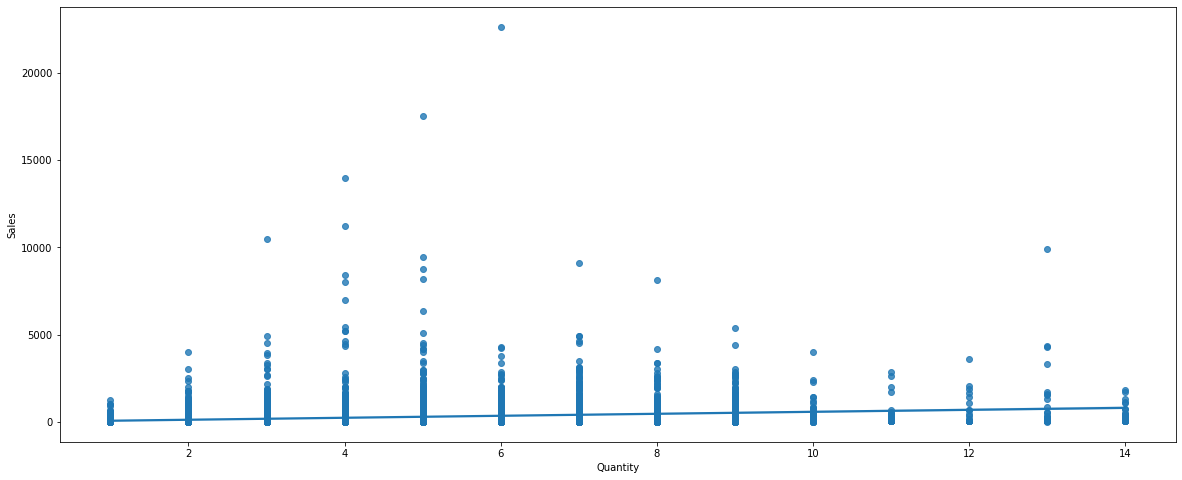

In [43]:
plt.figure(figsize = (20,8))
sns.regplot(x=GS_pd['Quantity'] , y=GS_pd['Sales'])

we can see higher sales amount for the lower quantities

also there is no strong correlation between quantity and sales

<AxesSubplot:xlabel='Sales'>

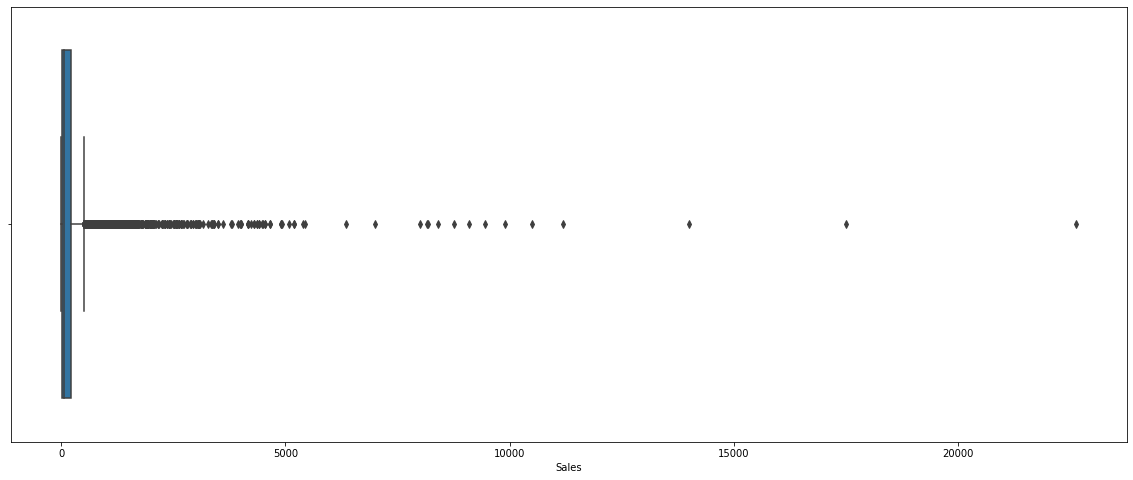

In [44]:
plt.figure(figsize = (20,8))

sns.boxplot(x= GS_pd['Sales'])

we can see some outliers in the sales column|

In [45]:
#lets find lower and upper limits of the sales distribution in order to find and remove outliers
q1 = np.nanpercentile(GS_pd['Sales'], 25)
q3 = np.nanpercentile(GS_pd['Sales'], 75)

iqr = q3 - q1
lower_lim = q1-1.5*iqr
upper_lim = q3+1.5*iqr
q1
print(lower_lim)
print(upper_lim)

-275.71
506.13


-275.71 is not valid for sales data. Therefore we can consider 0 to 507 range

<AxesSubplot:xlabel='Sales', ylabel='Count'>

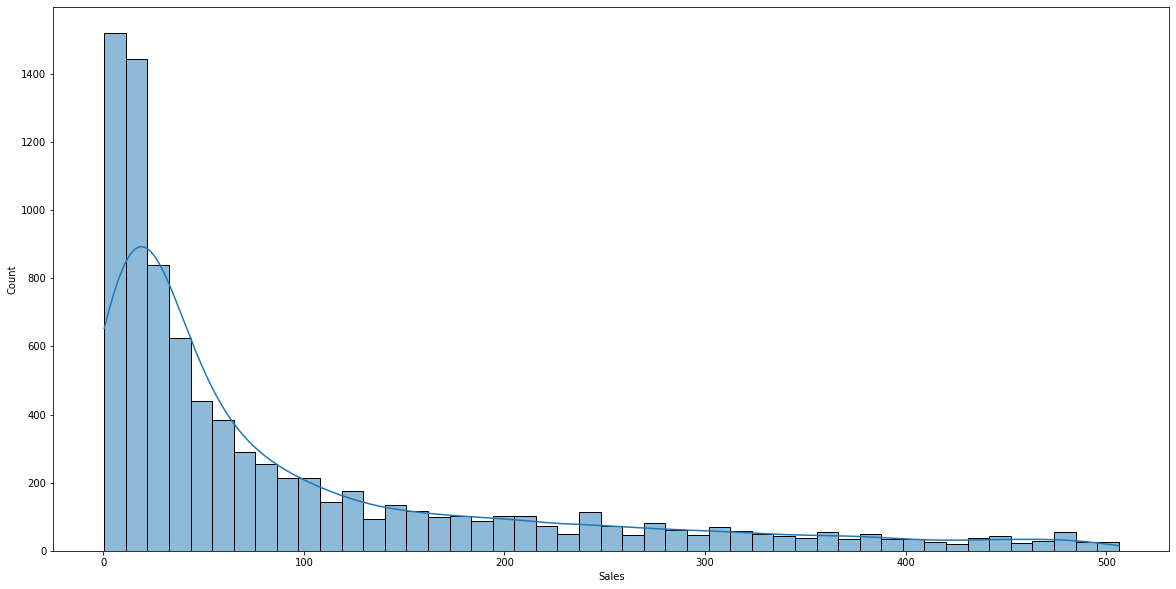

In [46]:
plt.figure(figsize = (20,10))
sns.histplot(x = GS_pd['Sales'][GS_pd['Sales']<507] , kde=True)

Sales data are right skewed indicates greater the sales amount lesser the count

<AxesSubplot:xlabel='Sales', ylabel='Count'>

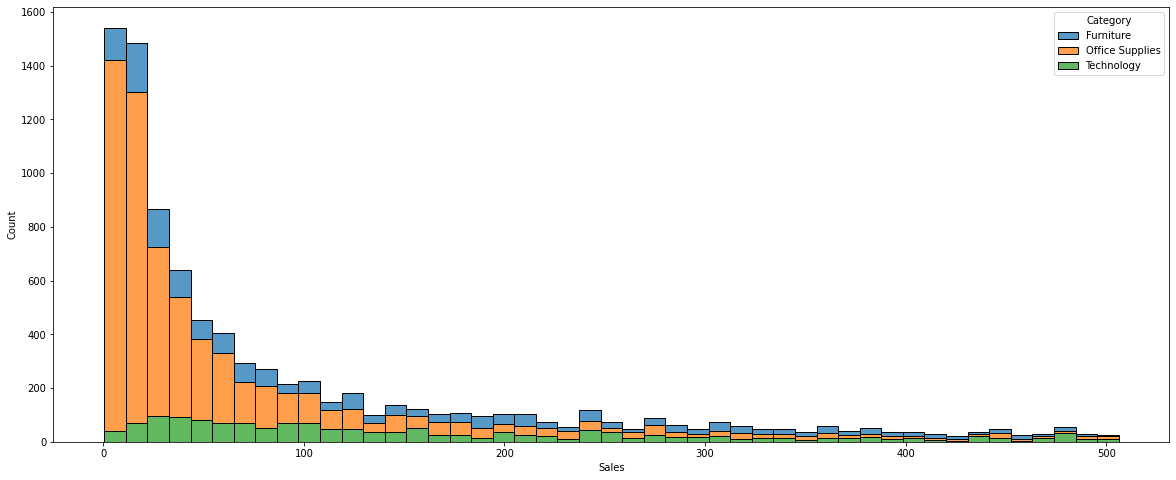

In [47]:
plt.figure(figsize = (20,8))
sales_prod = Sales_fact.join(Product_dim , on=Sales_fact['Product ID']==Product_dim['Product ID'] , how='inner')
sales_prod_pd = sales_prod.toPandas()
sns.histplot(x = sales_prod_pd['Sales'][sales_prod_pd['Sales']<507] ,  hue = sales_prod_pd['Category'],  multiple="stack" )

office supplies are more likely to sell

<AxesSubplot:xlabel='Regional Manager', ylabel='Sales'>

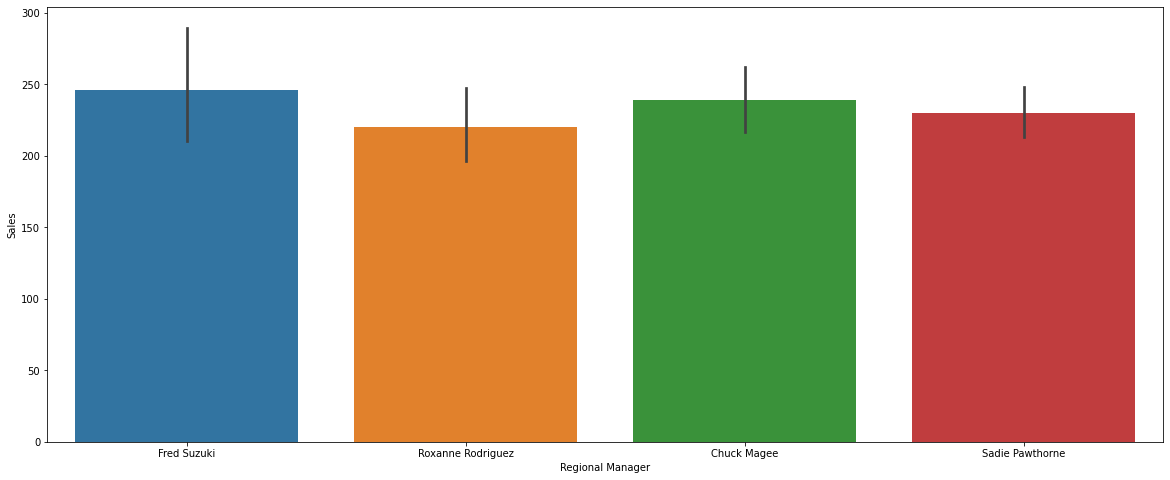

In [48]:
plt.figure(figsize = (20,8))
sales_emp = Sales_fact.join(Employee_dim , on=Sales_fact['Region']==Employee_dim['Region'] , how='inner')
sales_emp_pd = sales_emp.toPandas()
sns.barplot(x=sales_emp_pd['Regional Manager'] , y=sales_emp_pd['Sales'] )

Fred Suzuki and Chuck Magee seems to be equally contributed for sales while Roxanne Rodriguez has the least contribution

<Figure size 1440x720 with 0 Axes>

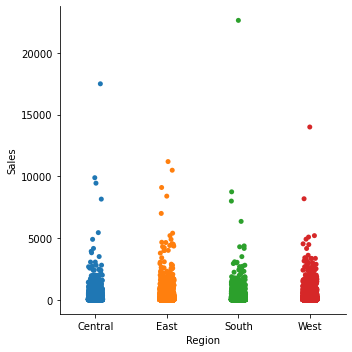

In [49]:
plt.figure(figsize = (20,10))
Sales_fact_pd = Sales_fact.toPandas()
sns.catplot(data=Sales_fact_pd, x="Region", y="Sales")

when we consider region and sales sales are seems to be equally distributed among the 4 regions

In [50]:
GS_Sales_Data_Combined.createOrReplaceTempView("GS_Sales_Data_Combined")

#Extract the year and sum(profit) from GS_Sales_Data_Combined to do some EDA between profit vs year
profit_by_year=spark.sql("""select EXTRACT(year FROM `Order Date`) as year,sum(Profit) as Profit
from GS_Sales_Data_Combined group by year""")

#convert spark dataframe into a pandas dataframe
profit_year_pd=profit_by_year.toPandas()

In [51]:
#Extract category,year sum(profit) from GS_Sales_Data_Combined to compare profit of categories among years
profit_and_category_by_year=spark.sql("""select EXTRACT(year FROM `Order Date`) as year,Category,sum(Profit) as Profit
from GS_Sales_Data_Combined group by year,Category""")
profit_and_category_by_year_pd=profit_and_category_by_year.toPandas()

[Text(0.5, 1.0, 'profit vs year ')]

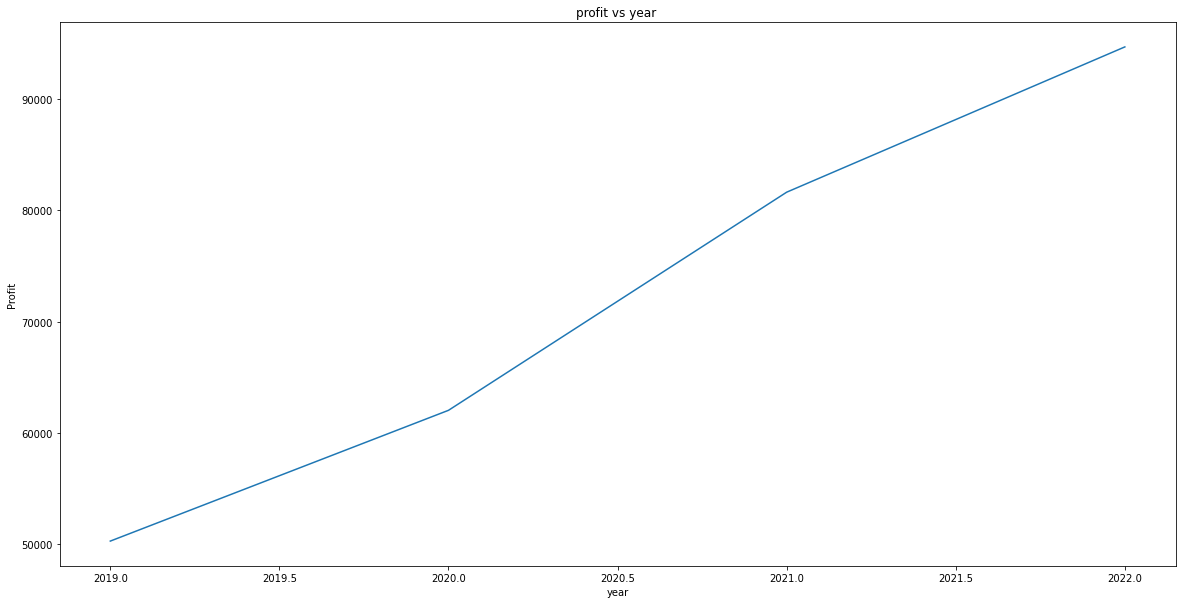

In [52]:
plt.figure(figsize = (20,10))
sns.lineplot(x = "year", y = "Profit" ,data = profit_year_pd,palette='Set2').set(title="profit vs year ")

There is a clear upward trend between years and profits

[Text(0.5, 1.0, 'profit variation in each product category and each year ')]

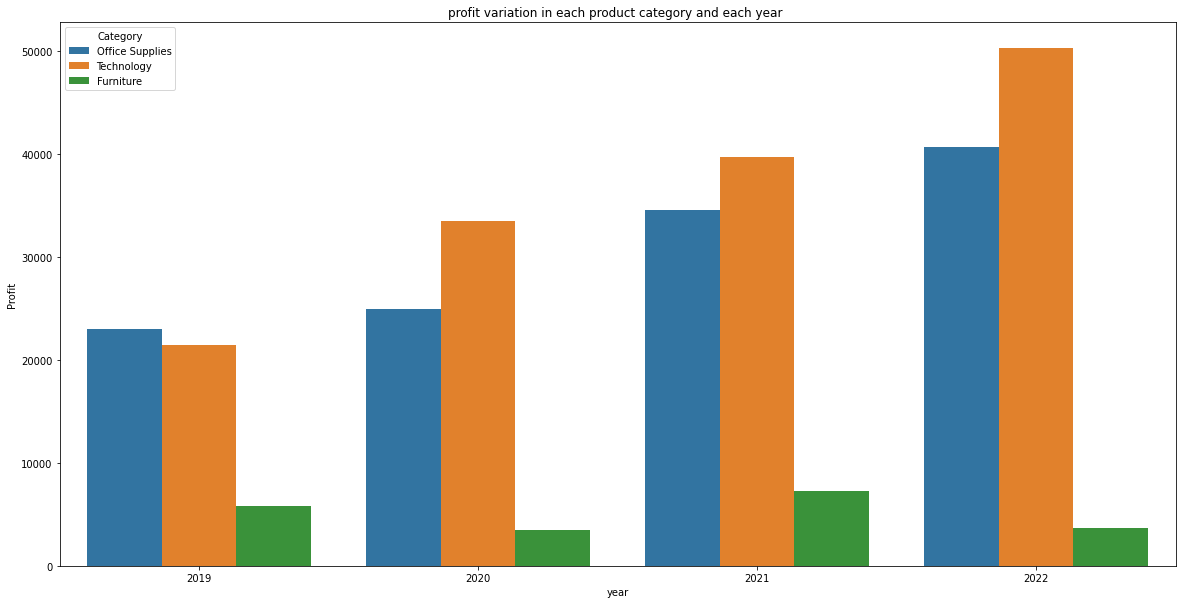

In [53]:
plt.figure(figsize = (20,10))
sns.barplot(x='year',hue='Category',y='Profit',data=profit_and_category_by_year_pd).set(title="profit variation in each product category and each year ")

every year technology category has the highest profit and it has increased year by year

furniture category has the least profit

In [54]:
#join all created fact and dimension tables to get an final table without null values
final_table = Sales_fact.join(Product_dim , Sales_fact['Product ID']==Product_dim['Product ID'] ,'inner').drop(Sales_fact['Product ID']).drop(Sales_fact['Product Name'])\
                        .join(Employee_dim , Sales_fact['Region']==Employee_dim['Region'] , 'inner').drop(Sales_fact['Region']).drop(Employee_dim['Region'])\
                        .join(state_dim.drop('Region') , Sales_fact['Postal Code']==state_dim['Postal Code'] , 'inner').drop(Sales_fact['Postal Code']).drop(Sales_fact['City']).drop(Sales_fact['Region'])\
                        .join(Customer_dim , Sales_fact['Customer ID']==Customer_dim['Customer ID'] , 'inner').drop(Sales_fact['Customer ID'])\
                        .join(Order_dim , Sales_fact['Order ID']==Order_dim['Order ID'] , 'inner').drop(Sales_fact['Order ID'])

final_table.printSchema()
final_table.show(5)

root
 |-- Returned: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Sales Target: integer (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)

In [55]:
#group the columns and get sum of them to calculate the revenue
final_table_grped=final_table.groupBy(['Category', 'Order Date','Segment','Sales Target']).sum('Sales','Quantity','Profit')
final_table_grped.show()

+---------------+----------+-----------+------------+------------------+-------------+------------------+
|       Category|Order Date|    Segment|Sales Target|        sum(Sales)|sum(Quantity)|       sum(Profit)|
+---------------+----------+-----------+------------+------------------+-------------+------------------+
|Office Supplies|2022-12-25|  Corporate|         377|           157.408|       274.62|53.221599999999995|
|     Technology|2020-03-29|   Consumer|          47|             53.25|          3.0|           20.7675|
|Office Supplies|2022-12-19|   Consumer|        1941|          1780.548|          6.0|27.164799999999996|
|Office Supplies|2020-12-23|   Consumer|         185|            194.32|          4.0|           56.3528|
|     Technology|2022-12-14|   Consumer|          38|            39.264|          3.0|            -4.908|
|Office Supplies|2021-01-28|  Corporate|          43|             39.68|          2.0|           10.3168|
|Office Supplies|2020-05-14|Home Office|      

In [56]:
#convert spark dataframe into a pandas dataframe
revenue = final_table_grped.toPandas()

In [57]:
#calculate and add revenue column to the revenue table
revenue['revenue'] = revenue['sum(Sales)'] - revenue['Sales Target']

In [58]:
#cast date type to str type to split the date in to year , month and days
revenue["Order Date"] = revenue["Order Date"].astype(str)

In [59]:
#split sthe order date column in to three seperate year , month and day columns
revenue[["year" ,"month" , "day"]] = revenue["Order Date"].str.split("-", expand = True)

In [60]:
revenue.head()

,Category,Order Date,Segment,Sales Target,sum(Sales),sum(Quantity),sum(Profit),revenue,year,month,day
0,Office Supplies,2022-12-25,Corporate,377,157.408,274.62,53.2216,-219.592,2022,12,25
1,Technology,2020-03-29,Consumer,47,53.250,3.00,20.7675,6.250,2020,03,29
2,Office Supplies,2022-12-19,Consumer,1941,1780.548,6.00,27.1648,-160.452,2022,12,19
3,Office Supplies,2020-12-23,Consumer,185,194.320,4.00,56.3528,9.320,2020,12,23
4,Technology,2022-12-14,Consumer,38,39.264,3.00,-4.9080,1.264,2022,12,14


In [61]:
#get revenues by year
revenue_grouped = revenue.groupby(['year']).sum()

In [62]:
#removr year column as index
revenue_grouped = revenue_grouped.reset_index()

In [63]:
revenue_grouped.head()

,year,Sales Target,sum(Sales),sum(Quantity),sum(Profit),revenue
0,2019,472684,508284.2131,10270.608,53447.2855,35936.2131
1,2020,455999,489987.5744,13298.675,65585.9624,36271.5744
2,2021,594935,632871.2890,16881.637,85121.7481,38734.2890
3,2022,714047,760107.6932,19831.990,99214.1417,46834.6932


[Text(0.5, 1.0, 'revenue vs year ')]

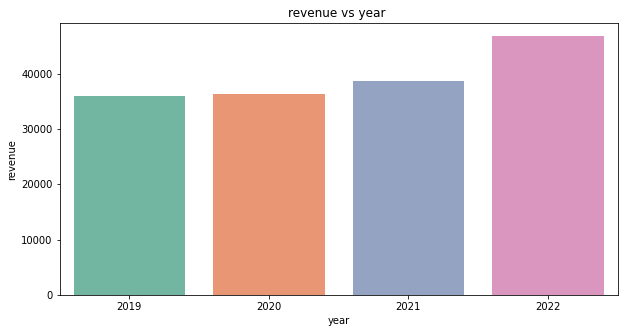

In [64]:
plt.figure(figsize = (10,5))
sns.barplot(x = "year", y = "revenue" ,data = revenue_grouped,palette='Set2').set(title="revenue vs year ")

the performance has increased gradually over the years, but a dramatic increase in performance can be seen in 2022.

In [65]:
#get revenue month wise
monthly_revenue = revenue.groupby(['year' , 'month']).sum()

[Text(0.5, 1.0, 'profit variation during each year ')]

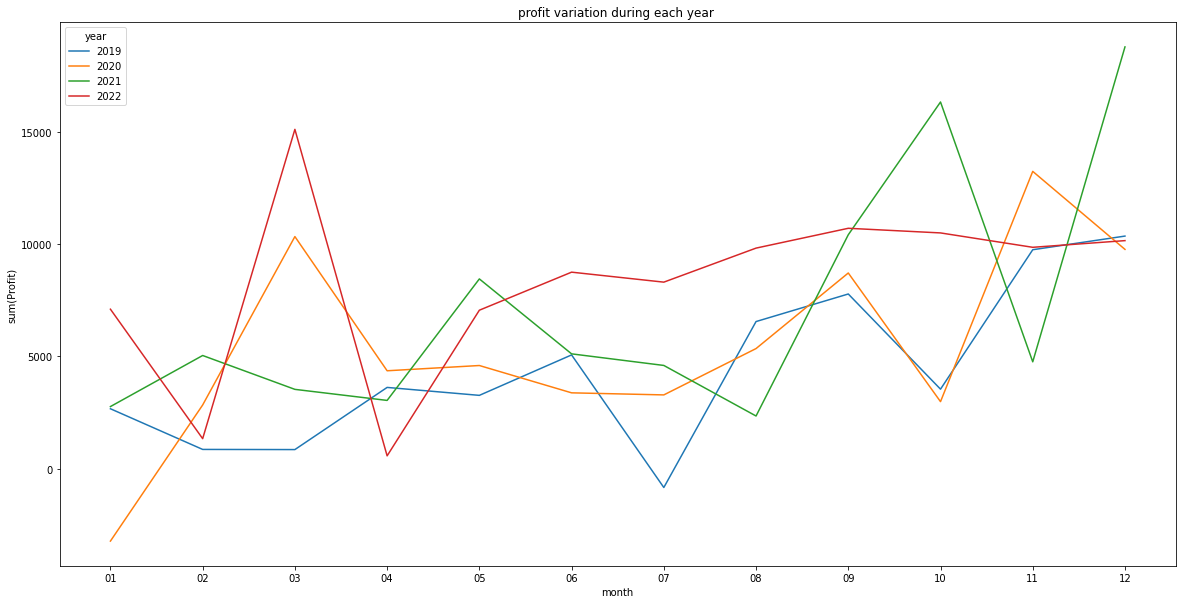

In [66]:
plt.figure(figsize=(20,10))
sns.lineplot(x = "month", y = "sum(Profit)", hue='year' ,data = monthly_revenue,palette='tab10').set(title="profit variation during each year ")

Every year profit has upward trend as month progress.  
2021 has recorded the highest profit margin at the december

In [67]:
final_table_grped=final_table.groupBy(['Category', 'Order Date','Segment','Sales Target']).sum('Sales','Quantity','Profit')

In [68]:
#get average  sales per order date
sales_vs_orderDate = GS_Sales_Data_Combined.groupBy(['Order Date']).avg('Sales')
sales_vs_orderDate.sort('Order Date')
sales_vs_orderDate = sales_vs_orderDate.toPandas()


In [69]:
sales_vs_orderDate["Order Date"] = sales_vs_orderDate["Order Date"].astype(str)
sales_vs_orderDate[["year" ,"month" , "day"]] = sales_vs_orderDate["Order Date"].str.split("-", expand = True)

In [70]:
#create year-month column by splitting order date column
sales_vs_orderDate["year-month"] = sales_vs_orderDate['year']+"-"+ sales_vs_orderDate["month"]

In [71]:
#drop other unnecessary columns
sales_vs_orderDate = sales_vs_orderDate.drop(['Order Date' , 'year' , 'month' , 'day'] , axis=1)

In [72]:
#calculate the mean per year-month
sales_vs_orderDate = sales_vs_orderDate.groupby('year-month').agg('mean').reset_index()

In [73]:
sales_vs_orderDate.head()

,year-month,avg(Sales)
0,2019-01,114.823197
1,2019-02,76.001450
2,2019-03,315.269786
3,2019-04,196.247664
4,2019-05,230.975235


<AxesSubplot:xlabel='year-month', ylabel='avg(Sales)'>

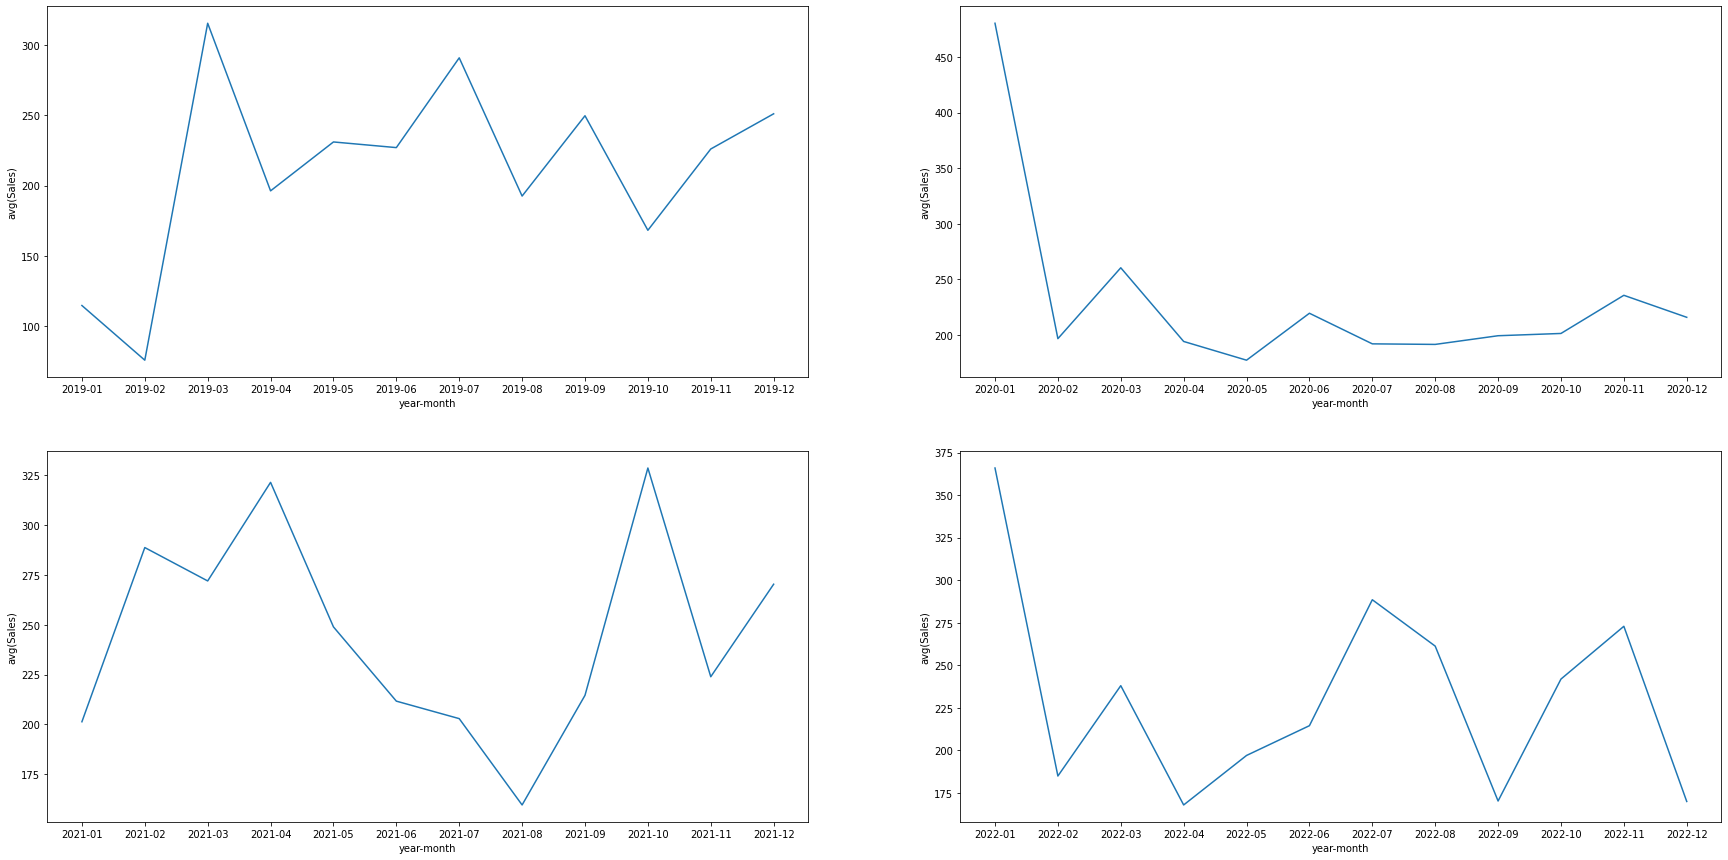

In [74]:
plt.figure(figsize = (30,15))
plt.subplot(2,2,1)
sns.lineplot(y = sales_vs_orderDate['avg(Sales)'].iloc[:12], x = sales_vs_orderDate['year-month'].iloc[:12])

plt.subplot(2,2,2)
sns.lineplot(y = sales_vs_orderDate['avg(Sales)'].iloc[12:24], x = sales_vs_orderDate['year-month'].iloc[12:24])

plt.subplot(2,2,3)
sns.lineplot(y = sales_vs_orderDate['avg(Sales)'].iloc[24:36], x = sales_vs_orderDate['year-month'].iloc[24:36])

plt.subplot(2,2,4)
sns.lineplot(y = sales_vs_orderDate['avg(Sales)'].iloc[36:48], x = sales_vs_orderDate['year-month'].iloc[36:48])


As we can see there is a high upward trend at the first quarter of 2019 and after that sligt downward trend can be seen.

At 2020 there is not considerable sales happend

At 2021 first quarter there is upward trend of sales and after that sales has dropped and in the last quarter again we can see an upward trend

In 2022 downward trend can be seen from the beginning

In [76]:
#Extract segment and sum(quantity) grouped ny year,week,segment to build the model
final_table.createOrReplaceTempView("final_table")
model = spark.sql("""select EXTRACT(WEEK FROM `Order Date`) as week,EXTRACT(year FROM `Order Date`) as year, 
Segment ,sum(Quantity) as Qty
from final_table group by year,week,Segment
order by year,week""")
model_pd = model.toPandas()

In [77]:
#create 3 different data frames according to 3 different segments
model_pd_corporate = model_pd[model_pd['Segment']=='Corporate'].reset_index()
model_pd_consumer = model_pd[model_pd['Segment']=='Consumer'].reset_index()
model_pd_homeOffice = model_pd[model_pd['Segment']=='Home Office'].reset_index()

In [78]:
#drop segment column from each dataframe since there is only one segment category in each dataframe
model_pd_corporate.drop(['Segment','index'],axis=1,inplace=True)
model_pd_consumer.drop(['Segment','index'],axis=1,inplace=True)
model_pd_homeOffice.drop(['Segment','index'],axis=1,inplace=True)

ADF Statistic: -6.9621047141158305
n_lags: 9.108729167452033e-10
p-value: 9.108729167452033e-10
Critial Values:
   1%, -3.4648754262570978
Critial Values:
   5%, -2.876714157488788
Critial Values:
   10%, -2.574858699001736
The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.
ADF Statistic: -10.09764142902617
n_lags: 1.0802350177113527e-17
p-value: 1.0802350177113527e-17
Critial Values:
   1%, -3.4652439354133255
Critial Values:
   5%, -2.8768752281673717
Critial Values:
   10%, -2.574944653739612
The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.


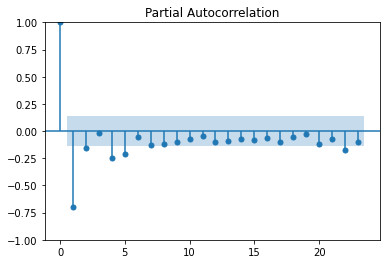

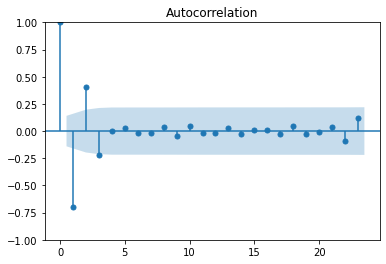

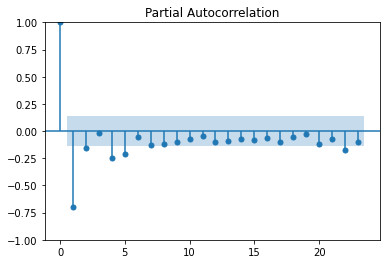

In [79]:
import warnings
warnings.filterwarnings('ignore')
#create a copy of model_pd_homeOffice
X1=model_pd_homeOffice.copy()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

#perform Augmented dickey fuller test
res=adfuller(X1.Qty)

#print results of the Augmented dickey fuller test
print(f'ADF Statistic: {res[0]}')
print(f'n_lags: {res[1]}')
print(f'p-value: {res[1]}')
for key, value in res[4].items():
  print('Critial Values:')
  print(f'   {key}, {value}')
if res[1]>0.05:
  print('The p-value is obtained is greater than significance level of 0.05. So the time series is in fact non-stationary.')
else:
  print('The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.')
print('====================================')

#perform order one differencing 
res_dif = adfuller(X1.Qty.diff().dropna())
print(f'ADF Statistic: {res_dif[0]}')
print(f'n_lags: {res_dif[1]}')
print(f'p-value: {res_dif[1]}')
for key, value in res_dif[4].items():
  print('Critial Values:')
  print(f'   {key}, {value}')
if res[1]>0.05:
  print('The p-value is obtained is greater than significance level of 0.05. So the time series is in fact non-stationary.')
else:
  print('The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.')
print('====================================')

#plot acf and pacf plots
plot_acf(X1.Qty.diff().dropna())
plot_pacf(X1.Qty.diff().dropna())

As we can see above after first order differencing p-value has dropped

In [80]:
#fit arima model and see the results
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
arima_model_HomeOffice=ARIMA(X1.Qty[:int(X1.shape[0]*.7)],order=(0,1,1))
arima_model_HomeOffice_fit=arima_model_HomeOffice.fit()
print(arima_model_HomeOffice_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  137
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -829.512
Date:                Thu, 16 Mar 2023   AIC                           1663.024
Time:                        06:04:22   BIC                           1668.849
Sample:                             0   HQIC                          1665.391
                                - 137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9959      0.125     -7.967      0.000      -1.241      -0.751
sigma2      1.125e+04   1110.867     10.130      0.000    9076.299    1.34e+04
Ljung-Box (L1) (Q):                   1.01   Jarque-

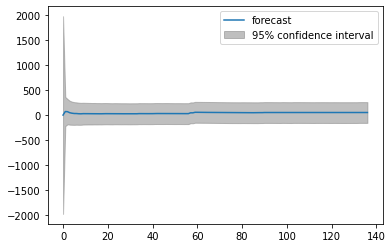

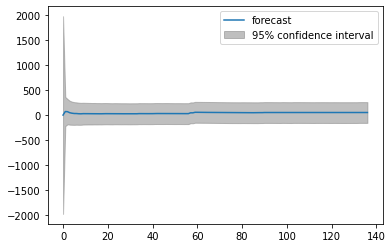

In [81]:
plot_predict(arima_model_HomeOffice_fit)

ADF Statistic: -3.505372742651941
n_lags: 0.007850178022100975
p-value: 0.007850178022100975
Critial Values:
   1%, -3.4631437906252636
Critial Values:
   5%, -2.8759570379821047
Critial Values:
   10%, -2.574454682874228
The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.
ADF Statistic: -11.504823524726245
n_lags: 4.401906406298473e-21
p-value: 4.401906406298473e-21
Critial Values:
   1%, -3.4633090972761744
Critial Values:
   5%, -2.876029332045744
Critial Values:
   10%, -2.5744932593252643
The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.


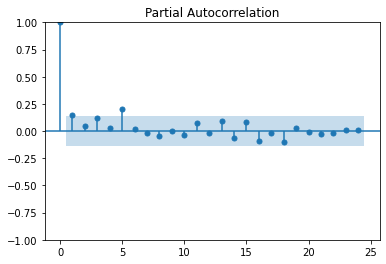

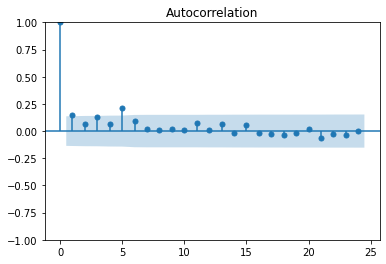

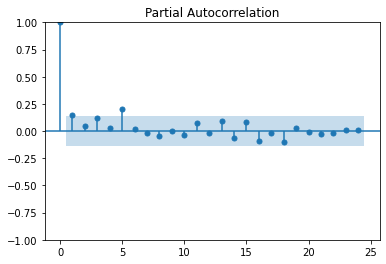

In [82]:
X2=model_pd_corporate.copy()

res2=adfuller(X2.Qty)
print(f'ADF Statistic: {res2[0]}')
print(f'n_lags: {res2[1]}')
print(f'p-value: {res2[1]}')
for key, value in res2[4].items():
  print('Critial Values:')
  print(f'   {key}, {value}')
if res2[1]>0.05:
  print('The p-value is obtained is greater than significance level of 0.05. So the time series is in fact non-stationary.')
else:
  print('The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.')
print('====================================')

res_dif2 = adfuller(X2.Qty.diff().dropna())
print(f'ADF Statistic: {res_dif2[0]}')
print(f'n_lags: {res_dif2[1]}')
print(f'p-value: {res_dif2[1]}')
for key, value in res_dif2[4].items():
  print('Critial Values:')
  print(f'   {key}, {value}')
if res_dif2[1]>0.05:
  print('The p-value is obtained is greater than significance level of 0.05. So the time series is in fact non-stationary.')
else:
  print('The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.')
print('====================================')

plot_acf(X2.Qty.dropna())
plot_pacf(X2.Qty.dropna())

In [83]:
arima_model_pd_corporate=ARIMA(X2.Qty[:int(X2.shape[0]*.7)],order=(1,0,1))
arima_model_pd_corporate_fit=arima_model_pd_corporate.fit()
print(arima_model_pd_corporate_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  144
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -886.022
Date:                Thu, 16 Mar 2023   AIC                           1780.043
Time:                        06:04:29   BIC                           1791.923
Sample:                             0   HQIC                          1784.870
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.4573     22.049      3.422      0.001      32.241     118.673
ar.L1         -0.9409      0.325     -2.893      0.004      -1.578      -0.303
ma.L1          0.9732      0.270      3.602      0.0

In [84]:
plot_predict(model_pd_corporate_fit)

NameError: ignored

In [85]:
X3=model_pd_consumer.copy()

ADF Statistic: -5.955818133475545
n_lags: 2.0945686311577538e-07
p-value: 2.0945686311577538e-07
Critial Values:
   1%, -3.4623415245233145
Critial Values:
   5%, -2.875606128263243
Critial Values:
   10%, -2.574267439846904
The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.
ADF Statistic: -8.156135434191041
n_lags: 9.409163276051846e-13
p-value: 9.409163276051846e-13
Critial Values:
   1%, -3.4638151713286316
Critial Values:
   5%, -2.876250632135043
Critial Values:
   10%, -2.574611347821651
The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.


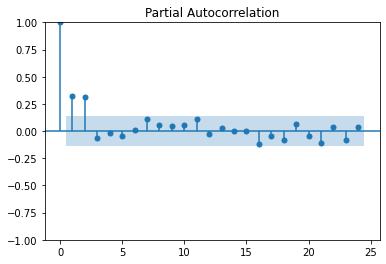

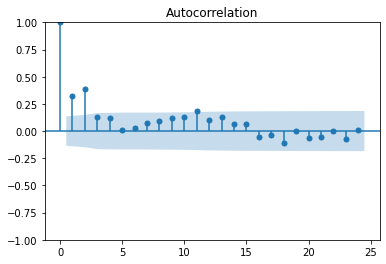

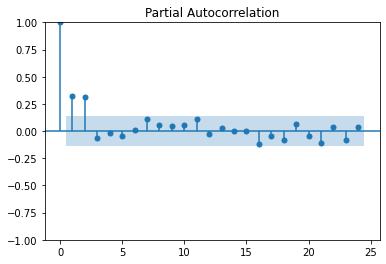

In [86]:
res3=adfuller(X3.Qty)
print(f'ADF Statistic: {res3[0]}')
print(f'n_lags: {res3[1]}')
print(f'p-value: {res3[1]}')
for key, value in res3[4].items():
  print('Critial Values:')
  print(f'   {key}, {value}')
if res3[1]>0.05:
  print('The p-value is obtained is greater than significance level of 0.05. So the time series is in fact non-stationary.')
else:
  print('The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.')
print('====================================')

res_dif3 = adfuller(X3.Qty.diff().dropna())
print(f'ADF Statistic: {res_dif3[0]}')
print(f'n_lags: {res_dif3[1]}')
print(f'p-value: {res_dif3[1]}')
for key, value in res_dif3[4].items():
  print('Critial Values:')
  print(f'   {key}, {value}')
if res_dif3[1]>0.05:
  print('The p-value is obtained is greater than significance level of 0.05. So the time series is in fact non-stationary.')
else:
  print('The p-value is obtained is less than significance level of 0.05. So the time series is in fact stationary.')
print('====================================')

plot_acf(X3.Qty.dropna())
plot_pacf(X3.Qty.dropna())

In [87]:
arima_model_pd_consumer=ARIMA(X3.Qty[:int(X3.shape[0]*.7)],order=(1,0,1))
arima_model_pd_consumer_fit=arima_model_pd_consumer.fit()
print(arima_model_pd_consumer_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  146
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -898.218
Date:                Thu, 16 Mar 2023   AIC                           1804.435
Time:                        06:04:32   BIC                           1816.370
Sample:                             0   HQIC                          1809.285
                                - 146                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        120.2126     25.458      4.722      0.000      70.316     170.110
ar.L1          0.6711      0.258      2.606      0.009       0.166       1.176
ma.L1         -0.4705      0.332     -1.417      0.1

In [88]:
plot_predict(model_pd_consumer_fit)

NameError: ignored

In [89]:
from sklearn.metrics import mean_absolute_error
y_pred1=arima_model_HomeOffice_fit.forecast(int(X1.shape[0]*.3)+1).tolist() 
mae1=mean_absolute_error(X1.Qty[int(X1.shape[0]*.7):] , y_pred1)
print('MAE model_Home_Office ',mae1)
y_pred2=arima_model_pd_corporate_fit.forecast(int(X2.shape[0]*.3)+1).tolist()
mae2=mean_absolute_error(X2.Qty[int(X2.shape[0]*.7):],y_pred2)
print('MAE model_Corporate ',mae2)
y_pred3=arima_model_pd_consumer_fit.forecast(int(X3.shape[0]*.3)+1).tolist()
mae3=mean_absolute_error(X3.Qty[int(X3.shape[0]*.7):],y_pred3)
print('MAE model_Consumer ',mae3)

print(f'average mae of the model is {np.mean([mae1,mae2,mae3])}')

MAE model_Home_Office  39.0056705155539
MAE model_Corporate  101.39280358509609
MAE model_Consumer  101.7915225065137
average mae of the model is 80.72999886905457


<AxesSubplot:xlabel='week', ylabel='Qty'>

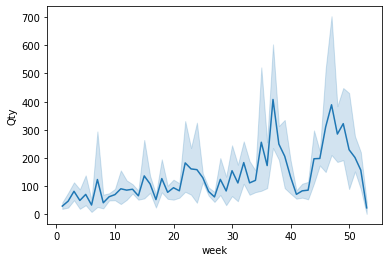

In [90]:
sns.lineplot(x="week",y='Qty',data=X3)